In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from numpy.random import seed
import tensorflow
from sklearn.metrics import precision_recall_fscore_support

In [2]:
path = "C:/Users/riasi/Desktop/dataset/COVID-19_Radiography_Dataset"

classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
num_classes = len(classes)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.2)

train_gen = train_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")

test_gen = test_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [3]:
model= Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), strides=2,activation='relu',
                 padding = 'Same',input_shape=(299, 299, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', strides=2,padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', 
              metrics=['Accuracy'])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5607488   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

In [5]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)
callbacks_list = [learning_rate_reduction,early_stopping_monitor]

In [12]:
model.fit(train_gen, validation_data = test_gen, epochs = 25, batch_size = 128, callbacks = [callbacks_list])

Epoch 1/25
1059/1059 [==============================] - 698s 658ms/step - loss: 0.9954 - Accuracy: 0.5699 - val_loss: 0.7939 - val_Accuracy: 0.6574
Epoch 2/25
1059/1059 [==============================] - 429s 405ms/step - loss: 0.8765 - Accuracy: 0.6333 - val_loss: 0.7515 - val_Accuracy: 0.6671
Epoch 3/25
1059/1059 [==============================] - 519s 490ms/step - loss: 0.8323 - Accuracy: 0.6549 - val_loss: 0.6747 - val_Accuracy: 0.7424
Epoch 4/25
1059/1059 [==============================] - 470s 444ms/step - loss: 0.8072 - Accuracy: 0.6719 - val_loss: 0.6543 - val_Accuracy: 0.7405
Epoch 5/25
1059/1059 [==============================] - 451s 426ms/step - loss: 0.7737 - Accuracy: 0.6904 - val_loss: 0.6410 - val_Accuracy: 0.7465
Epoch 6/25
1059/1059 [==============================] - 435s 411ms/step - loss: 0.7443 - Accuracy: 0.6984 - val_loss: 0.6060 - val_Accuracy: 0.7502
Epoch 7/25
1059/1059 [==============================] - 436s 411ms/step - loss: 0.7350 - Accuracy: 0.7057 - val_

In [18]:
model.save('cnn_basic.h5')

In [6]:
cnn_basic = keras.models.load_model('cnn_basic.h5')

In [7]:
y_pred_basic = cnn_basic.predict(test_gen)

In [8]:
y_true_basic = test_gen.classes
predictions_basic = np.array(list(map(lambda x: np.argmax(x), y_pred_basic)))
class_report_basic = classification_report(y_true_basic, predictions_basic, target_names = ['Covid-19', 'Lung Opacity', 'Healthy', 'Pneumonia'])

In [9]:
print(class_report_basic)

              precision    recall  f1-score   support

    Covid-19       0.75      0.76      0.76       723
Lung Opacity       0.87      0.71      0.78      1202
     Healthy       0.82      0.93      0.87      2038
   Pneumonia       0.88      0.67      0.76       269

    accuracy                           0.82      4232
   macro avg       0.83      0.77      0.79      4232
weighted avg       0.82      0.82      0.82      4232



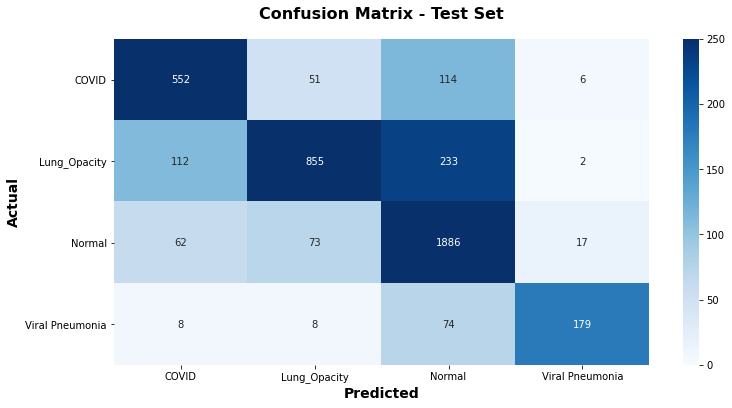

In [10]:
CMatrix_basic = pd.DataFrame(confusion_matrix(y_true_basic, predictions_basic), columns=classes, index =classes)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix_basic, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Overall Results: 
Accuracy Result: 82.04%
Precision Result: 82.83%
Recall Result: 76.64%
F-Score Result: 79.10%


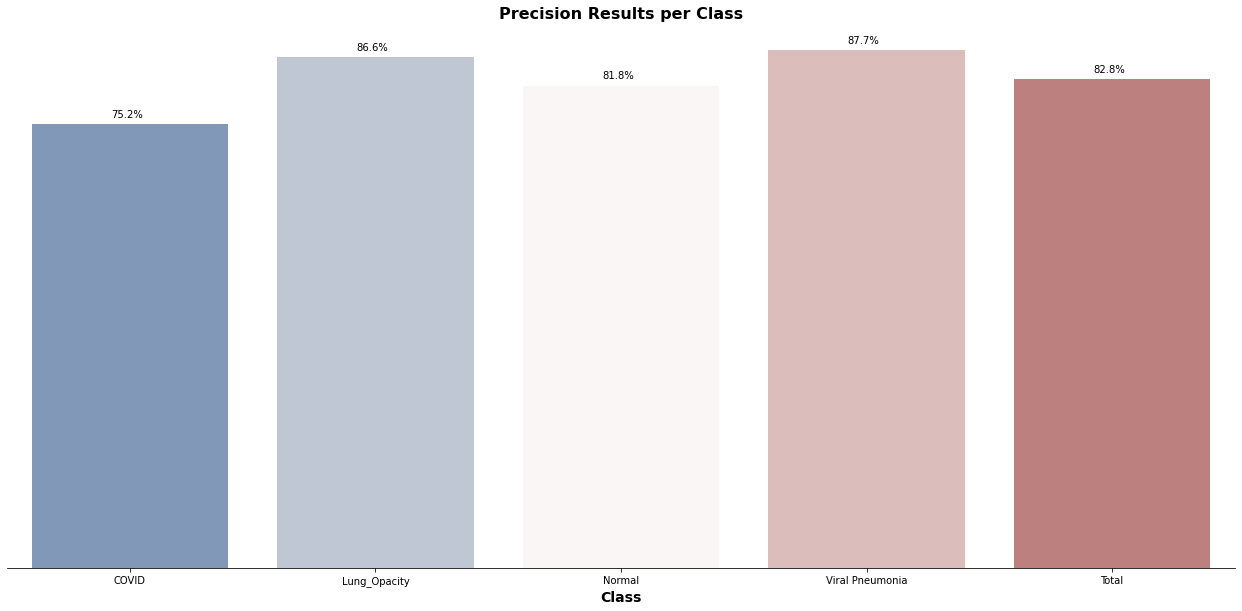

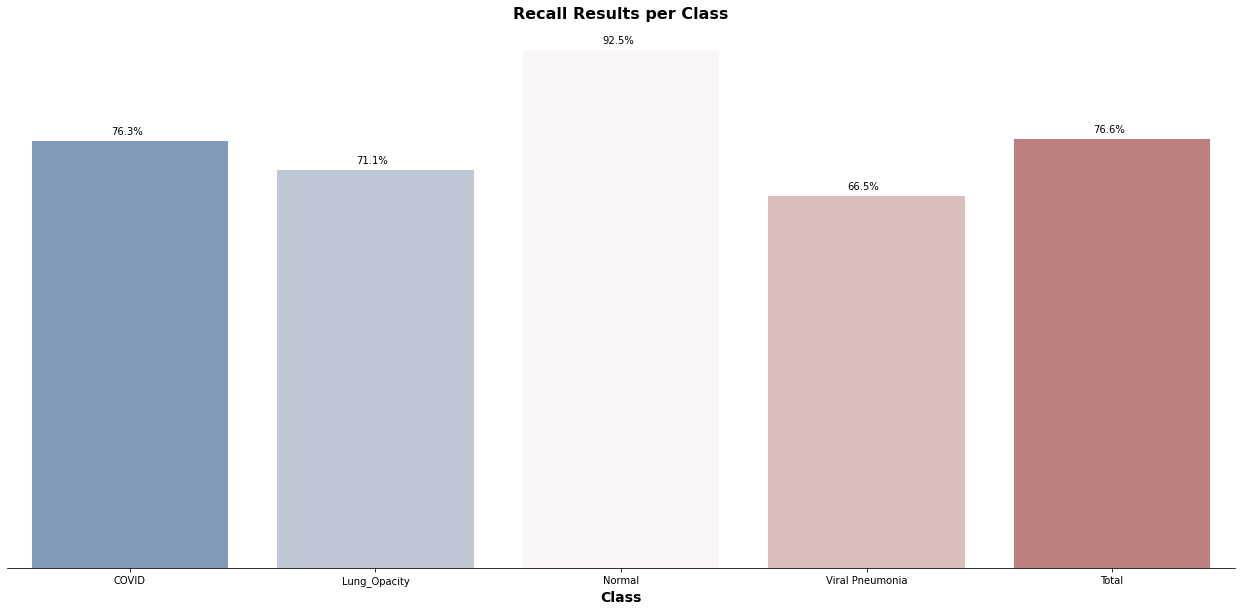

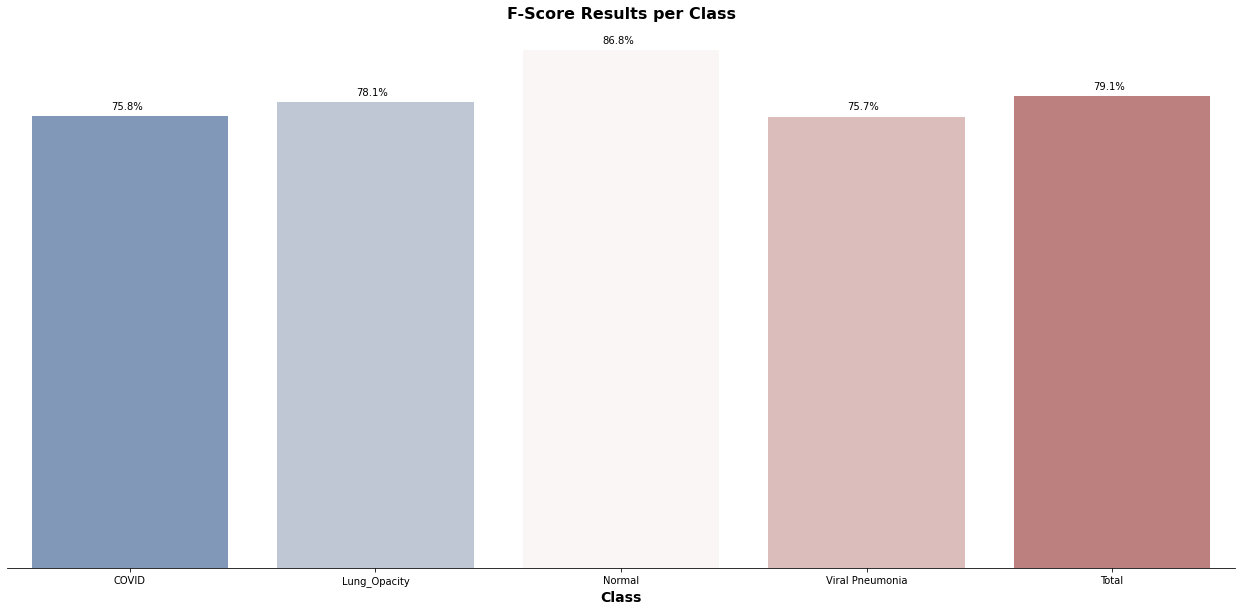

In [12]:
acc = accuracy_score(y_true_basic, predictions_basic)

results_all = precision_recall_fscore_support(y_true_basic, predictions_basic, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_true_basic, predictions_basic, average=None, zero_division=1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "vlag")
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');

metrics_plot(all_df, 'Precision')
metrics_plot(all_df, 'Recall')
metrics_plot(all_df, 'F-Score')
print('Overall Results: ')
print('Accuracy Result: %.2f%%'%(acc*100))
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))

In [13]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',strides = 2, 
                  padding = 'Same',input_shape=(299, 299, 1)))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu',strides = 2, padding = 'Same'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(4, activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', 
               metrics=['Accuracy'])

In [14]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)            

In [46]:
model2.fit(train_gen, validation_data = test_gen, epochs = 20, batch_size = 128, callbacks = [callbacks_list])

Epoch 1/20
1059/1059 [==============================] - 751s 708ms/step - loss: 1.0332 - Accuracy: 0.5852 - val_loss: 1.8248 - val_Accuracy: 0.4901
Epoch 2/20
1059/1059 [==============================] - 722s 682ms/step - loss: 0.8549 - Accuracy: 0.6432 - val_loss: 3.1339 - val_Accuracy: 0.4877
Epoch 3/20
1059/1059 [==============================] - 585s 553ms/step - loss: 0.7993 - Accuracy: 0.6710 - val_loss: 1.2938 - val_Accuracy: 0.5865
Epoch 4/20
1059/1059 [==============================] - 3538s 3s/step - loss: 0.7698 - Accuracy: 0.6827 - val_loss: 7.9872 - val_Accuracy: 0.4813
Epoch 5/20
1059/1059 [==============================] - 2292s 2s/step - loss: 0.7548 - Accuracy: 0.6921 - val_loss: 0.7957 - val_Accuracy: 0.6831
Epoch 6/20
1059/1059 [==============================] - 515s 486ms/step - loss: 0.7593 - Accuracy: 0.6882 - val_loss: 1.2004 - val_Accuracy: 0.5853
Epoch 7/20
1059/1059 [==============================] - 510s 481ms/step - loss: 0.7565 - Accuracy: 0.6878 - val_loss

In [48]:
model2.save('cnn_batchNorm.h5')

In [15]:
cnn_batchNorm = keras.models.load_model('cnn_batchNorm.h5')

In [16]:
y_pred_batchNorm = cnn_batchNorm.predict(test_gen)

In [17]:
y_true_batchNorm = test_gen.classes
predictions_batchNorm = np.array(list(map(lambda x: np.argmax(x), y_pred_batchNorm)))
class_report_batchNorm = classification_report(y_true_batchNorm, predictions_batchNorm, target_names = ['Covid-19', 'Lung Opacity', 'Healthy', 'Pneumonia'])

In [18]:
print(class_report_batchNorm)

              precision    recall  f1-score   support

    Covid-19       0.65      0.68      0.66       723
Lung Opacity       0.81      0.70      0.75      1202
     Healthy       0.82      0.87      0.84      2038
   Pneumonia       0.79      0.80      0.79       269

    accuracy                           0.78      4232
   macro avg       0.77      0.76      0.76      4232
weighted avg       0.78      0.78      0.78      4232



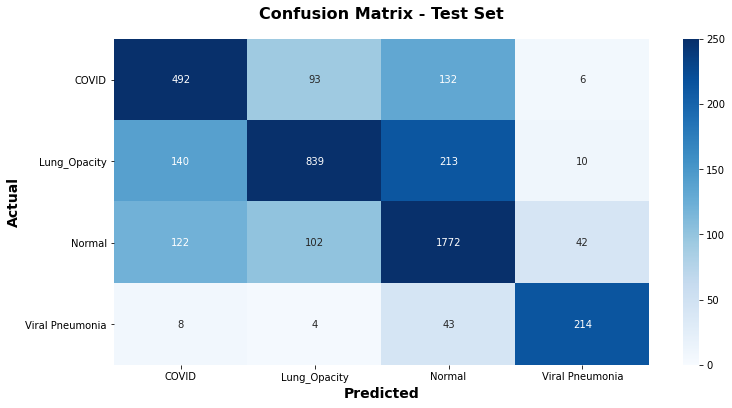

In [19]:
CMatrix_batchNorm = pd.DataFrame(confusion_matrix(y_true_batchNorm, predictions_batchNorm), columns=classes, index =classes)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix_batchNorm, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Overall Results: 
Accuracy Result: 78.38%
Precision Result: 76.53%
Recall Result: 76.09%
F-Score Result: 76.18%


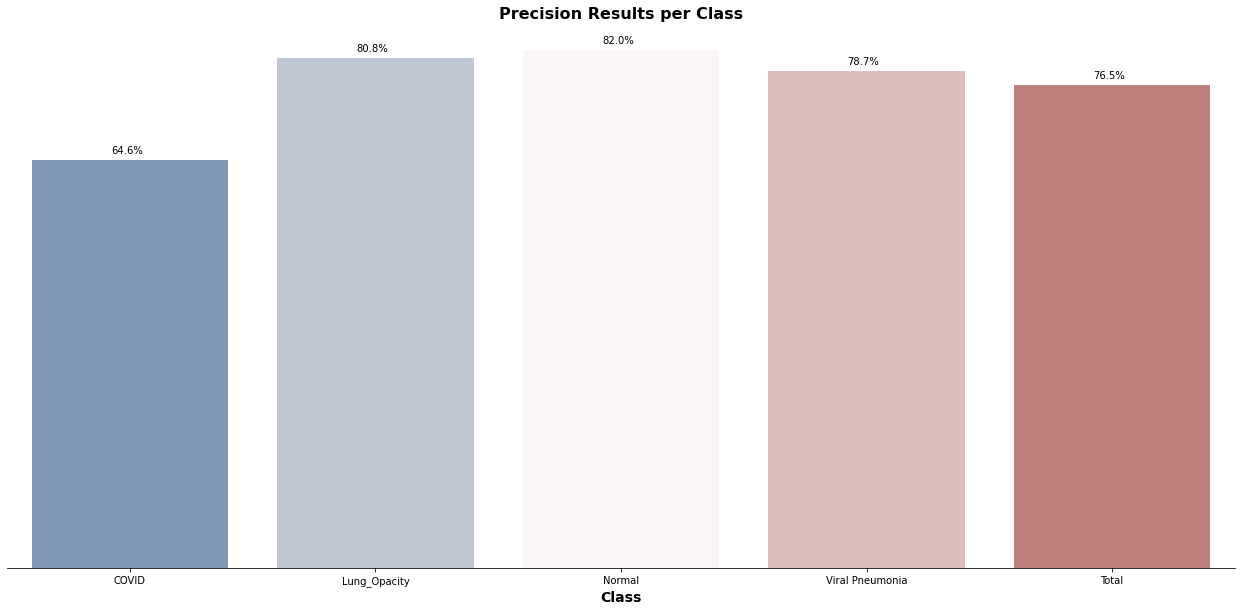

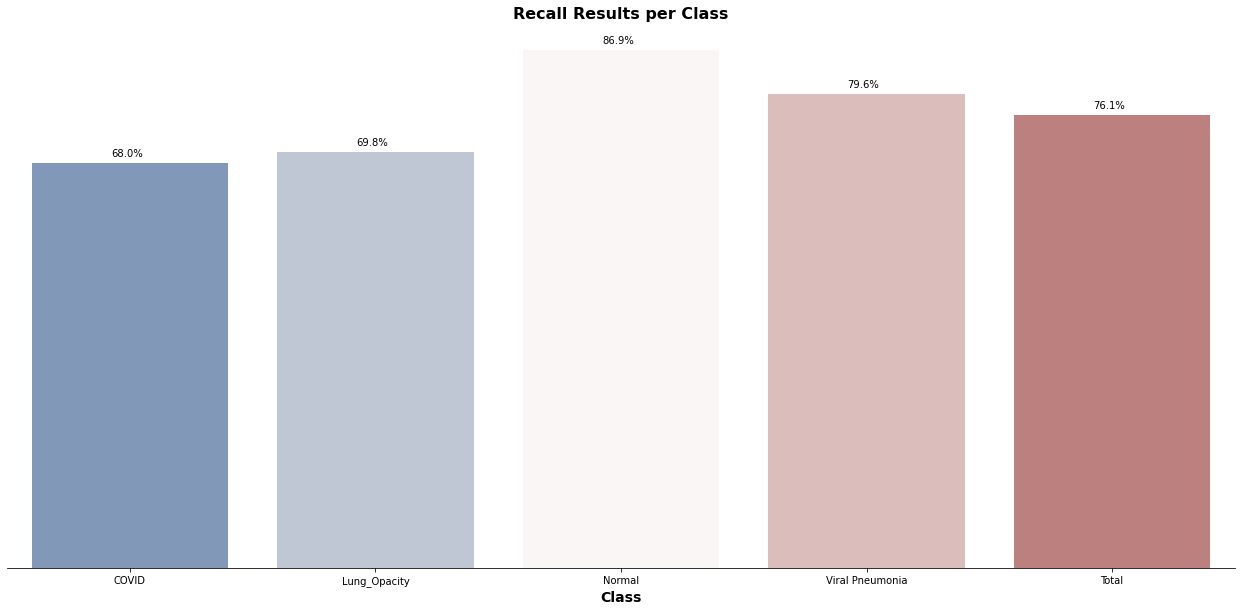

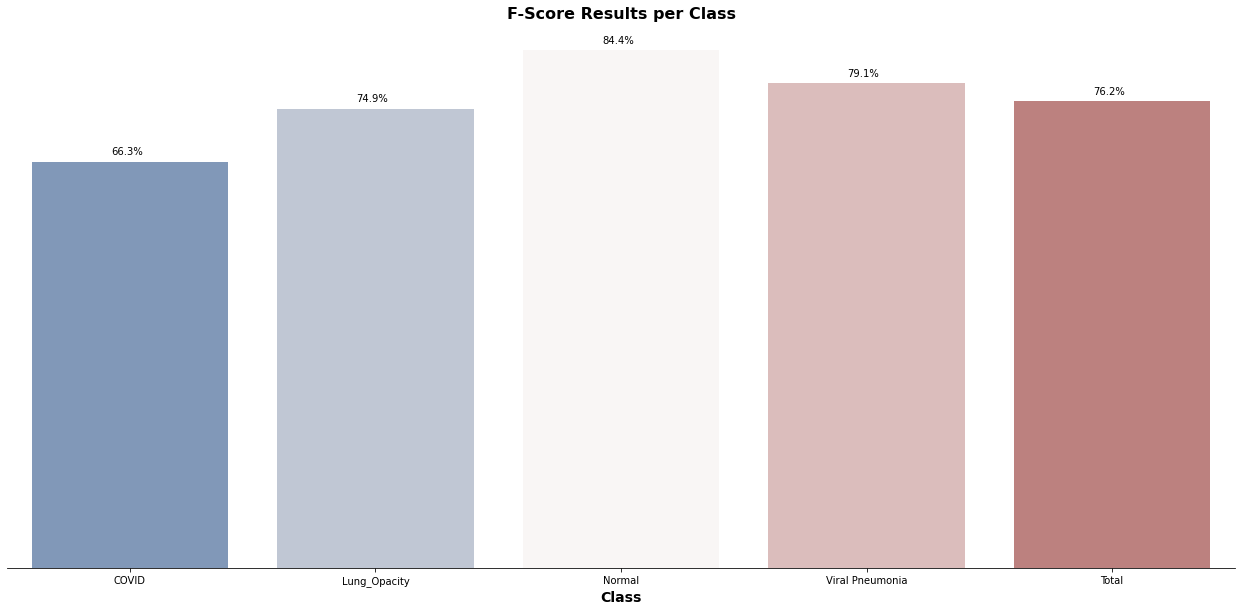

In [20]:
acc = accuracy_score(y_true_batchNorm, predictions_batchNorm)

results_all = precision_recall_fscore_support(y_true_batchNorm, predictions_batchNorm, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_true_batchNorm, predictions_batchNorm, average=None, zero_division=1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "vlag")
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');

metrics_plot(all_df, 'Precision')
metrics_plot(all_df, 'Recall')
metrics_plot(all_df, 'F-Score')
print('Overall Results: ')
print('Accuracy Result: %.2f%%'%(acc*100))
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))

In [21]:
a = {'BASIC CNN' : 0.82, 'NORMALISED CNN' :0.783, 'ALEXNET' : 0.85, 'INCEPTION V3' :0.77}

In [22]:
import pandas as pd

In [23]:
df = pd.DataFrame(data = a, columns = ['model', 'accuracy'])

In [24]:
df

,model,accuracy


In [25]:
df.model = ['Basic CNN', 'Normalised CNN', 'AlexNet', 'InceptionV3']

In [26]:
df

,model,accuracy
0,Basic CNN,NaN
1,Normalised CNN,NaN
2,AlexNet,NaN
3,InceptionV3,NaN


In [27]:
df.accuracy = [0.82, 0.783, 0.85, 0.77]

In [28]:
df

,model,accuracy
0,Basic CNN,0.820
1,Normalised CNN,0.783
2,AlexNet,0.850
3,InceptionV3,0.770


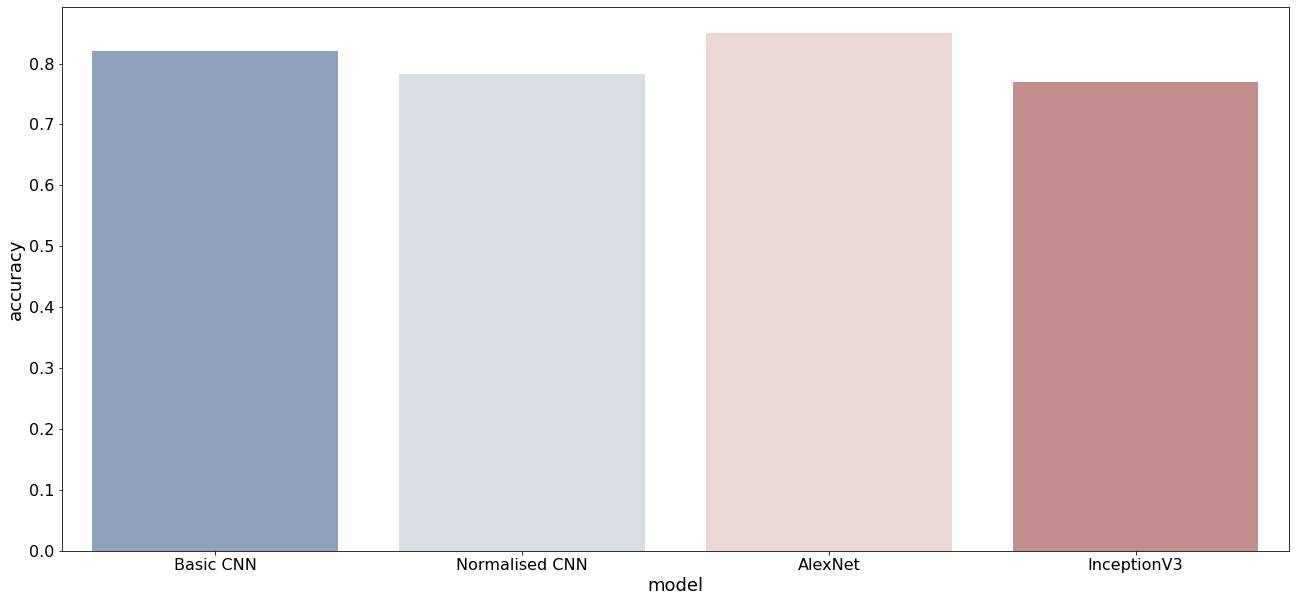

In [29]:
plt.figure(figsize = (22,10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax = sns.barplot(data =df, x=df.model, y = df.accuracy,palette = "vlag")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)